## **Predicción de la vida útil restante (RUL) del motor de turbofán basado en Ciencia de Datos y Aprendizaje Automático (XGBoost).**

Usar XGBoost como modelo baseline para predecir la Remaining Useful Life (RUL) en el dataset C-MAPSS es una elección estratégica, ya que combina la capacidad de modelar relaciones no lineales complejas con eficiencia computacional y buenas prácticas de regularización que previenen el sobreajuste. Como algoritmo basado en boosting de árboles, XGBoost permite capturar interacciones sutiles entre sensores y condiciones operativas, y responde bien a variaciones en el preprocesamiento, como el suavizado, escalado por condición o codificación de variables categóricas. Al incluirlo como modelo base, se pueden obtener insights más refinados sobre la utilidad de diferentes transformaciones, lo que facilita la toma de decisiones para trasladar estas estrategias a modelos más sofisticados como redes LSTM o Transformers.

En este notebook nos enfocaremos en el desarrollo del Modelo de regresión lineal con XGboost, el EDA y la importancia del estudio fueron desarrollados en el notebook Predicting Remaining Useful Life (RUL). Entonces se realizará varios experimentos donde:

- CARGAR LOS DATOS CONCATNEADOS
- PREPARACION DE DATOS (AÑADIR LA RUL, AÑADIR LAS OPERACIONES POR CONDICIÓN, clip RUL, etc)
- SE REALIZARA UN MODELO LINEAL BASE (COMPARAR RESULTADOS).
- SE IMPLEMENTARA XGboost CON AJUSTE DE HYPERPARÁMETROS.
- SE VISUALIZARAN CURVAS DE APRENDIZAJE.
- SE OBSERVARAN LAS CARACTERISTICAS MÁS IMPORTANTES.
- CONCLUSIONES


### **DESARROLLO**

#### **RECOLECCIÓN DE DATOS.**

La mayoría de los estudios empiezan con FD001 aplicando diferentes modelos hasta el más desafiante que es FD004 con modelos más complejos. Para este estudio nos centraremos en un modelo generalista, un modelo práctico para un entorno real que funcione en diferentes condiciones operativas (distintas condiciones de fallo, múltiples motores, diferentes regímenes de estrés), es decir concatenaremos los subset de datos, como los subconjuntos provienen de la misma distribución (mismo tipo de motores, mismos sensores, misma metodología de recolección) y solo varían en condiciones operativas, esto puede tener muchas ventajas como  aumentar la diversidad de datos y mejorar la robustez del modelo, ayudar a evitar overfitting y mejorar el entrenamiento de modelos de Machine Learning.

In [2]:
#Librerias importadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve # cruva de aprendizaje
import joblib
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import random
import os


In [3]:
# Configuración de la semilla para reproducibilidad
# Esta función establece la semilla para la reproducibilidad en experimentos de aprendizaje automático.
# Asegúrate de que todas las librerías relevantes usen la misma semilla para garantizar resultados consistentes.
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # Para reproducibilidad en hash de Python

# Llamar a la función para establecer la semilla
set_seed(42)
SEED = 42

In [4]:
#SEGMENTO DONDE DEFINO FUNCIONES A UTILIZAR

# Esta función evalúa el desempeño de un modelo de regresión
def evaluate(y_true, y_hat, label='test'):
    """
    Evalúa el desempeño de un modelo de regresión utilizando RMSE y R².

    Parámetros:
    y_true -- valores reales de la variable dependiente (array o lista)
    y_hat -- valores predichos por el modelo (array o lista)
    label -- etiqueta opcional para identificar el conjunto evaluado (por defecto: 'test')
    """

    # Calcula el Error Cuadrático Medio (MSE)
    mse = mean_squared_error(y_true, y_hat)
    # Calcula la Raíz del MSE (RMSE), que indica el error promedio en las mismas unidades que la variable dependiente
    rmse = np.sqrt(mse)
    # Calcula el Coeficiente de Determinación (R²), que mide la proporción de varianza explicada por el modelo
    variance = r2_score(y_true, y_hat)

    # Imprime los resultados de evaluación con una etiqueta
    print(f'{label} set RMSE: {rmse:.4f}, R²: {variance:.4f}')

def add_remaining_useful_life(df):
    """
    Añade la columna RUL (Remaining Useful Life) al dataframe C-MAPSS.

    Parámetros:
    df -- DataFrame con datos de los sensores, que debe incluir las columnas 'unit_nr' y 'time_cycles'

    Retorna:
    Un nuevo DataFrame con una columna adicional llamada 'RUL'
    """

    # Paso 1: Calcular el número máximo de ciclos por cada unidad (motor)
    # Esto representa el ciclo en el que la unidad falló (fin de su vida útil)
    max_cycles_per_unit = df.groupby("unit_nr")["time_cycles"].transform('max')

    # Paso 2: Calcular el Remaining Useful Life restando el ciclo actual al máximo ciclo
    df["RUL"] = max_cycles_per_unit - df["time_cycles"]

    # Retornar el DataFrame modificado con la columna RUL añadida
    return df



In [5]:
def add_operating_conditions(df, alt_col='altitude', mach_col='mach', temp_col='temperature'):
    """
    Añade una columna 'operating_condition_id' al DataFrame en base a las combinaciones únicas
    de altitud, Mach y temperatura (redondeadas para evitar ruido).

    Parámetros:
    - df: DataFrame original con las columnas de altitud, Mach y temperatura.
    - alt_col, mach_col, temp_col: Nombres de las columnas correspondientes.

    Devuelve:
    - El DataFrame original con una nueva columna 'operating_condition_id'.
    - Un DataFrame con las combinaciones únicas de condiciones operativas.
    """
    df_grouped = df.copy()

    # Redondeo para agrupar correctamente condiciones similares
    df_grouped['alt'] = df_grouped[alt_col].round(0)
    df_grouped['Mach'] = df_grouped[mach_col].round(2)
    df_grouped['TRA'] = df_grouped[temp_col].round(1)

    # Crear tupla de condición operativa y asignar códigos únicos
    df_grouped['operating_condition'] = df_grouped[['alt', 'Mach', 'TRA']].apply(tuple, axis=1)
    df_grouped['operating_condition_id'] = df_grouped['operating_condition'].astype('category').cat.codes

    # Asignar la columna al DataFrame original
    df['operating_condition_id'] = df_grouped['operating_condition_id'].astype(int)

    # También retorna las combinaciones únicas y sus conteos por si lo necesitas
    condition_counts = df_grouped.groupby('operating_condition_id').size().reset_index(name='count')
    unique_conditions = df_grouped[['operating_condition_id', 'alt', 'Mach', 'TRA']].drop_duplicates()
    unique_conditions = unique_conditions.merge(condition_counts, on='operating_condition_id')

    return df, unique_conditions

In [6]:
def scaling_by_condition(df_train, df_test, feature_columns, condition_column='operating_condition_id'):
    """
    Estandariza características por condición operativa, guardando los parámetros de escalamiento
    
    Args:
        df_train (pd.DataFrame): DataFrame de entrenamiento
        df_test (pd.DataFrame): DataFrame de prueba
        feature_columns (list): Lista de columnas a escalar
        condition_column (str): Columna que define las condiciones operativas
        
    Returns:
        tuple: (df_train_scaled, df_test_scaled, scalers_dict) 
               donde scalers_dict contiene los escaladores por condición
    """
    scalers_dict = {}
    
    # Crear copias para no modificar los DataFrames originales
    train_scaled = df_train.copy()
    test_scaled = df_test.copy()
    
    for condition in df_train[condition_column].unique():
        # Crear y ajustar scaler solo con datos de entrenamiento
        scaler = StandardScaler()
        scaler.fit(df_train.loc[df_train[condition_column]==condition, feature_columns])
        
        # Guardar scaler para uso futuro
        scalers_dict[condition] = scaler
        
        train_scaled[feature_columns] = train_scaled[feature_columns].astype('float64')
        test_scaled[feature_columns] = test_scaled[feature_columns].astype('float64')
        
        # Transformar datos de entrenamiento y prueba
        train_scaled.loc[df_train[condition_column]==condition, feature_columns] = scaler.transform(
            df_train.loc[df_train[condition_column]==condition, feature_columns])
        
        # Solo transformar datos de prueba si la condición existe en test
        if condition in df_test[condition_column].unique():
            test_scaled.loc[df_test[condition_column]==condition, feature_columns] = scaler.transform(
                df_test.loc[df_test[condition_column]==condition, feature_columns])
    
    return train_scaled, test_scaled

In [7]:
def time_series_smoothing(
    df: pd.DataFrame,
    group_columns: list = ["unit_nr"],
    feature_columns: list = None,
    alpha: float = 0.4,
    n_samples: int = 1
) -> pd.DataFrame:
    """
    Aplica suavizado exponencial a series temporales agrupadas y elimina muestras iniciales.

    Parámetros:
        df: DataFrame de entrada.
        group_columns: Columnas para agrupar (ej: ["unit_nr", "flight_id"]).
        feature_columns: Columnas a suavizar.
        alpha: Factor de suavizado (0 < alpha <= 1).
        n_samples: Muestras iniciales a eliminar por grupo.

    Retorna:
        DataFrame procesado.
    """
    df = df.copy()
    
    # 1. Suavizado Exponencial
    smoothed = (
        df.groupby(group_columns, sort=False)[feature_columns]
        .apply(lambda x: x.ewm(alpha=alpha).mean())
        .reset_index(level=0, drop=True)  # Alinear índices
    )
    
    df[feature_columns] = smoothed
    
    return df

In [8]:
# URL
FD=1
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# definir el nombre de las columnas para fácil adaptación
index_names = ['unit_nr', 'time_cycles']
setting_names = ['altitude', 'mach', 'temperature']
sensor_names = ["t2", "t24", "t30", "t50",
    "p2", "p15", "p30",
    "nf", "nc",
    "epr", "ps30", "phi",
    "nrf", "nrc", "bpr", "farb", "htbleed",
    "nf_dmd", "pcnfr_dmd",
    "w31", "w32"]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])



In [9]:
# URL
FD=2
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# leer dataset
train2 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test2 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test2 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])


In [10]:
# URL
FD=3
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# read data
train3 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test3 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test3 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])


In [11]:
# URL
FD=4
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# read data
train4 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test4 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test4 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])

In [12]:
# Encontrar el valor máximo de unit_nr en train
max_unit_nr = train["unit_nr"].max()
# Ajustar los valores de unit_nr en train4 sumando el valor máximo de train esto para añadir secuecia en los motores
train2["unit_nr"] += max_unit_nr
max_unit_nr2 = train2["unit_nr"].max()
train3["unit_nr"] += max_unit_nr2
max_unit_nr3 = train3["unit_nr"].max()
train4["unit_nr"] += max_unit_nr3

# Concatenar los DataFrames por filas (axis=0)
train_final = pd.concat([train,train2,train3,train4], axis=0, ignore_index=True)

In [13]:
# Combinar los datos de prueba con las etiquetas RUL
test['RUL'] = y_test['RUL']
test2['RUL'] = y_test2['RUL']
test3['RUL'] = y_test3['RUL']
test4['RUL'] = y_test4['RUL']

# Encontrar el valor máximo de unit_nr en train
max_unit_nr = test["unit_nr"].max()
# Ajustar los valores de unit_nr en train4 sumando el valor máximo de train
test2["unit_nr"] += max_unit_nr
max_unit_nr2 = test2["unit_nr"].max()
test3["unit_nr"] += max_unit_nr2
max_unit_nr3 = test3["unit_nr"].max()
test4["unit_nr"] += max_unit_nr3

test_final = pd.concat([test,test2,test3,test4], axis=0, ignore_index=True)

In [14]:
# Guardar los datos de entrenamiento en un CSV
#train_final.to_csv('cmapps_entrenamiento_concatenado.csv', index=False)

# Guardar los datos de prueba en un CSV
#test_final.to_csv('cmapps_prueba_concatenado.csv', index=False)

#print("Archivos CSV generados con éxito: 'cmapps_entrenamiento_concatenado.csv' y 'cmapps_prueba_concatenado.csv'.")

In [15]:
train=train_final.copy()
test=test_final.copy()

#### **PREPARACIÓN DE DATOS**

In [16]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['altitude'] = df_op_cond['altitude'].round()
    df_op_cond['mach'] = df_op_cond['mach'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['operating_condition_id'] = df_op_cond['altitude'].astype(str) + '_' + \
                        df_op_cond['mach'].astype(str) + '_' + \
                        df_op_cond['temperature'].astype(str)
    
    return df_op_cond

In [17]:
train[['htbleed', 'nf_dmd']] = train[['htbleed', 'nf_dmd']].astype(float)
test[['htbleed', 'nf_dmd']] = test[['htbleed', 'nf_dmd']].astype(float)

In [18]:
X_train=add_remaining_useful_life(train) #añadir el RUL al dataset

In [19]:
#X_train, unique_conditions = add_operating_conditions(train)
#unique_conditions

X_train = add_operating_condition(train)


In [20]:
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)# esta es con la clip

In [21]:
#X_test,unique_test=add_operating_conditions(test) #añado al conjunto de prueba la caratristica de los modos de operación

X_test=add_operating_condition(test) #añado al conjunto de prueba la caratristica de los modos de operación

In [22]:
# Dado que los valores RUL reales del conjunto de prueba solo se proporcionan para el último ciclo de cada motor,
# el conjunto de prueba se subdivide para representar lo mismo.
y_test = X_test.pop('RUL') #rul real
y_test = y_test[y_test.notna()].reset_index(drop=True)
y_test_clipped=y_test.clip(upper=125)# esta es con la clip
X_test = X_test.groupby('unit_nr').last().reset_index()#Agrupo por unidad y me quedo con la última fila de cada grupo

In [23]:
X_train_encoded = pd.get_dummies(X_train, columns=['operating_condition_id']).drop(columns=index_names+setting_names,axis=1)
X_test_encoded = pd.get_dummies(X_test, columns=['operating_condition_id']).drop(columns=index_names+setting_names,axis=1)

### **MODELO.**

Random Forest (RF) y XGBoost comparten la base de estar construidos sobre árboles de decisión y ser modelos capaces de capturar relaciones no lineales complejas entre variables, la idea es realizar los experimentos de RF y analizar  resultaods, así como la importancia de características.

#### **REGRESIÓN LINEAL XGBOOST (EXPERIMENTO 1).**

Modelo optimizado sin preprocesamiento de datos, solo con las características de sensores y configuración

##### Proceso.

In [38]:

# Definir el pipeline para Random Forest
xg_pipeline1 = Pipeline([
    ('model', XGBRegressor(objective='reg:squarederror', random_state=SEED, verbosity=0))
])

# Definir espacio de búsqueda
param_grid_xgb1 = {
    'model__n_estimators': [100, 200],        # Número de árboles
    'model__max_depth': [3, 10],           # Profundidad máxima
    'model__learning_rate': [0.01, 0.1, 1], # Tasa de aprendizaje
    'model__subsample': [0.8, 1.0],           # Porcentaje de muestras por árbol
    'model__colsample_bytree': [0.8, 1.0],     # Porcentaje de features por árbol
    'model__reg_alpha': [0.1, 1],
    'model__reg_lambda': [1]
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

In [39]:
# Optimización con GridSearchCV para XGboost.
grid_xg1 = GridSearchCV(xg_pipeline1, param_grid_xgb1, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_xg1.fit(X_train[setting_names+sensor_names], y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-67.816, test=-67.592) r2: (train=0.342, test=0.343) total time=   2.3s
[CV 2/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-67.675, test=-67.673) r2: (train=0.344, test=0.344) total time=   1.1s
[CV 3/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-67.756, test=-67.374) r2: (train=0.343, test=0.345) total time=   1.9s
[CV 4/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, mod

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_polic...
                                                     random_state=42, ...))]),
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 1],
                         'model__max_depth': [3, 10],
                         'model__n_estimators': [100, 200],
                         'model__reg_alpha': [0.1, 1], 'model__reg_lambda': [1],
                         'model__subsample': [0.8, 1.0]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [40]:
best_grid_xg1 = grid_xg1.best_estimator_

# Comparación de resultados
rf_rmse1 = -grid_xg1.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse1:.4f}, Mejor configuración: {grid_xg1.best_params_}")

Mejor RMSE Random Forest: 49.9918, Mejor configuración: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 1.0}


##### Resultado.

In [ ]:
y_pred_train_1 = best_grid_xg1.predict(X_train[setting_names+sensor_names])
y_pred_test_1 = best_grid_xg1.predict(X_test[setting_names+sensor_names])

evaluate(y_train, y_pred_train_1, 'train')
evaluate(y_test.clip(upper=125), y_pred_test_1)

train set RMSE: 42.4201, R²: 0.7421
test set RMSE: 40.2905, R²: 0.0835


#### **REGRESIÓN LINEAL XGBOOST + CLIP RUL (EXPERIMENTO 2).**

En este caso reentrenaremos el mejor modelo optimizado, encontrado anteriormente pero ahora con la variable objetivo adaptada (CLIP RUL) y estandar escaler global.

##### Reentreno

In [43]:
##### Reentreno
XG_reeval = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(
        objective='reg:squarederror', 
        random_state=SEED, 
        verbosity=0,
        learning_rate=0.1,
        n_estimators=100, 
        max_depth=10,                
        subsample = 1.0,                
        colsample_bytree=0.8,        
        reg_alpha = 1,
        reg_lambda = 1
        ))
])

In [ ]:
# Entrenamiento y evaluación
XG_reeval.fit(X_train[setting_names+sensor_names], y_train_clipped)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Guardar grid_rf
#joblib.dump(XG_reeval, 'XG_reeval.pkl')

#print("Modelo guardado exitosamente: 'XG_reeval.pkl'.")

Modelo guardado exitosamente: 'XG_reeval.pkl'.


In [46]:
# Cargar el GridSearchCV completo
#XG_reeval = joblib.load('XG_reeval.pkl')

#print("Modelo cargado exitosamente.")

In [47]:
y_pred_2 = XG_reeval.predict(X_test[setting_names+sensor_names])
y_pred_train_2 = XG_reeval.predict(X_train[setting_names+sensor_names])

##### Resultado.

In [48]:
evaluate(y_train_clipped, y_pred_train_2, 'train')
evaluate(y_test.clip(upper=125), y_pred_2)

train set RMSE: 14.7826, R²: 0.8715
test set RMSE: 18.3919, R²: 0.8090


#### **REGRESIÓN LINEAL XGBOOST + ONE HOT ENCONDING (EXPERIMENTO 3).**

La idea es añadir One Hot Enconding al modelo anterior con escaler global, y verificar si en el modelo no lineal pues mejora en algo con las dummies. 

##### Proceso.

In [49]:
# Columnas numéricas.
numeric_features = ['t2', 't24', 't30', 't50', 'p2', 'p15', 'p30', 'nf', 'nc', 'epr', 
                   'ps30', 'phi', 'nrf', 'nrc', 'bpr', 'farb', 'htbleed', 'nf_dmd', 
                   'pcnfr_dmd', 'w31', 'w32']

# Columnas categóricas.
categorical_features = ['operating_condition_id']

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Preprocessor unificado
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='drop')  # Ignora columnas no listadas

In [51]:
# Definir el pipeline para Random Forest
xg_pipeline3 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=SEED, verbosity=0))
])

# Definir espacio de búsqueda
param_grid_xgb3 = {
    'model__n_estimators': [100, 200],        # Número de árboles
    'model__max_depth': [3, 10],           # Profundidad máxima
    'model__learning_rate': [0.01, 0.1, 1], # Tasa de aprendizaje
    'model__subsample': [0.8, 1.0],           # Porcentaje de muestras por árbol
    'model__colsample_bytree': [0.8, 1.0],     # Porcentaje de features por árbol
    'model__reg_alpha': [0.1, 1],
    'model__reg_lambda': [1]
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)

In [52]:
# Ajusta el preprocesador
preprocessor.fit(X_train[sensor_names+['operating_condition_id']])

# Obtén los nombres de las columnas de salida
feature_names = preprocessor.get_feature_names_out()

print("Columnas de salida:")
print(feature_names)

Columnas de salida:
['scaler__t2' 'scaler__t24' 'scaler__t30' 'scaler__t50' 'scaler__p2'
 'scaler__p15' 'scaler__p30' 'scaler__nf' 'scaler__nc' 'scaler__epr'
 'scaler__ps30' 'scaler__phi' 'scaler__nrf' 'scaler__nrc' 'scaler__bpr'
 'scaler__farb' 'scaler__htbleed' 'scaler__nf_dmd' 'scaler__pcnfr_dmd'
 'scaler__w31' 'scaler__w32' 'onehot__operating_condition_id_0'
 'onehot__operating_condition_id_1' 'onehot__operating_condition_id_2'
 'onehot__operating_condition_id_3' 'onehot__operating_condition_id_4'
 'onehot__operating_condition_id_5']


In [53]:
grid_xg3 = GridSearchCV(xg_pipeline3, param_grid_xgb3, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_xg3.fit(X_train[sensor_names+['operating_condition_id']], y_train_clipped)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-30.339, test=-30.386) r2: (train=0.459, test=0.456) total time=   1.1s
[CV 2/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-30.337, test=-30.247) r2: (train=0.459, test=0.462) total time=   1.3s
[CV 3/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-30.349, test=-30.356) r2: (train=0.458, test=0.459) total time=   1.3s
[CV 4/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, mod

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['t2',
                                                                          't24',
                                                                          't30',
                                                                          't50',
                                                                          'p2',
                                                                          'p15',
                                                                          'p30',
                                                                          'nf',
                                                                          'nc',
                                                                          'epr',
                                                                          'ps30',
                                                                          'phi',
                                                                          'nrf',
                                                                          'nrc',
                                                                          'bpr',
                                                                          'farb',
                                                                          'htbleed',
                                                                          'nf_dmd',
                                                                          'pcnfr_dmd',
                                                                          'w31',
                                                                          'w32']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown=...
                                                     random_state=42, ...))]),
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 1],
                         'model__max_depth': [3, 10],
                         'model__n_estimators': [100, 200],
                         'model__reg_alpha': [0.1, 1], 'model__reg_lambda': [1],
                         'model__subsample': [0.8, 1.0]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
# Guardar grid_rf
#joblib.dump(grid_xg3, 'grid_xg3.pkl')

#print("Modelo guardado exitosamente: 'grid_xg3.pkl'.")

Modelo guardado exitosamente: 'grid_xg3.pkl'.


In [55]:
# Cargar el GridSearchCV completo
#grid_rf3 = joblib.load('grid_rf3.pkl')

#print("Modelo cargado exitosamente.")

In [56]:
best_grid_xg3 = grid_xg3.best_estimator_

# Comparación de resultados
rf_rmse3 = -grid_xg3.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse3:.4f}, Mejor configuración: {grid_xg3.best_params_}")

Mejor RMSE Random Forest: 18.0104, Mejor configuración: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 1.0}


##### Resultado.

In [57]:
y_pred_train_3 = best_grid_xg3.predict(X_train[sensor_names+['operating_condition_id']])
y_pred_test_3 = best_grid_xg3.predict(X_test[sensor_names+['operating_condition_id']])

evaluate(y_train_clipped, y_pred_train_3, 'train')
evaluate(y_test.clip(upper=125), y_pred_test_3)

train set RMSE: 14.9724, R²: 0.8682
test set RMSE: 18.3047, R²: 0.8108


##### **IMPORTANCIA DE CARACTERÍSTICAS.**

In [83]:
features=sensor_names+['operating_condition_id_0',
       'operating_condition_id_1', 'operating_condition_id_2',
       'operating_condition_id_3', 'operating_condition_id_4',
       'operating_condition_id_5']

In [84]:
importances = best_grid_xg3.named_steps['model'].feature_importances_

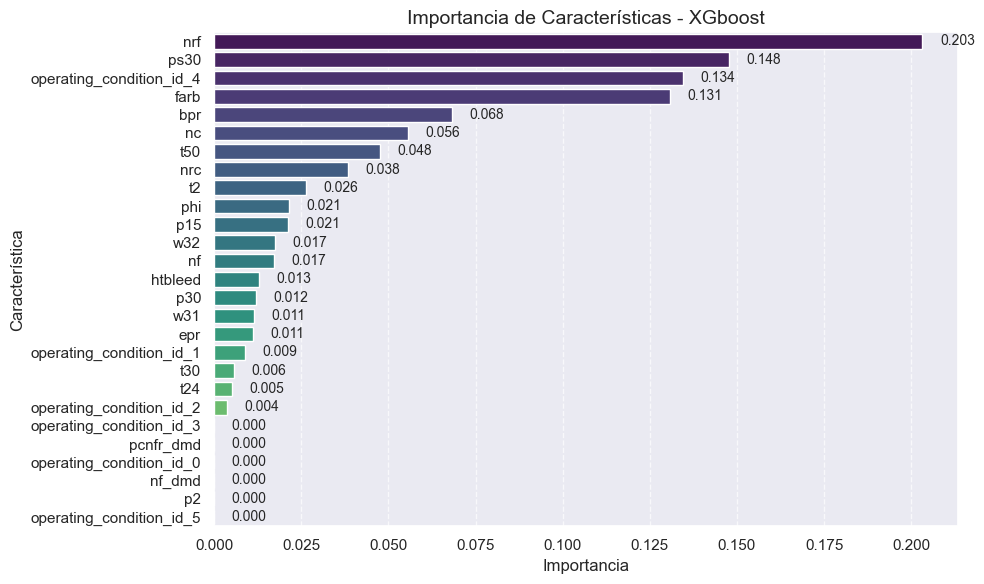

In [85]:
# Ordenar las importancias
# Crear dataframe de importancias
feat_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=feat_importances,
    x='Importance',
    y='Feature',
    color='#440154',  # Color principal de Viridis (puedes cambiarlo)
    hue='Feature',    # Asignamos hue para usar palette
    palette='viridis', # Paleta Viridis completa
    dodge=False,      # Evita que separen las barras
    legend=False      # No mostrar leyenda redundante
)

# Personalización del gráfico
plt.title('Importancia de Características - XGboost', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores de importancia a cada barra
for index, value in enumerate(feat_importances['Importance']):
    plt.text(value + 0.005,             # Posición X (valor + pequeño desplazamiento)
            index,                     # Posición Y (índice de la barra)
            f'{value:.3f}',            # Texto con 3 decimales
            va='center',               # Alineación vertical al centro
            fontsize=10)               # Tamaño de fuente

plt.tight_layout()
plt.show()

#### **REGRESIÓN LINEAL XGboost + ONE HOT ENCONDING + ESCALADO POR CONDICIÓN (EXPERIMENTO 4).**

La idea es verificar el desempeño de modelo no lineal frente a el escalado por condición de operación.

##### Proceso.

In [24]:
sensor_names = sensor_names
condition_column = 'operating_condition_id'
group_column = 'unit_nr'

In [25]:
# ------------------------------
# ConditionScaler personalizado
# ------------------------------
from sklearn.base import BaseEstimator, TransformerMixin


class ConditionScaler(BaseEstimator, TransformerMixin):
    def __init__(self, feature_columns, condition_column='operating_condition_id'):
        self.feature_columns = feature_columns
        self.condition_column = condition_column
        self.scalers_dict_ = {}
        
    def fit(self, X, y=None):
        X = X.astype({col: 'float64' for col in self.feature_columns})
        for condition in X[self.condition_column].unique():
            scaler = StandardScaler()
            scaler.fit(X.loc[X[self.condition_column] == condition, self.feature_columns])
            self.scalers_dict_[condition] = scaler
        return self
        
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.feature_columns] = X_scaled[self.feature_columns].astype('float64')
        for condition, scaler in self.scalers_dict_.items():
            mask = X[self.condition_column] == condition
            X_scaled.loc[mask, self.feature_columns] = scaler.transform(X.loc[mask, self.feature_columns])
        return X_scaled

In [65]:
onehot_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), [condition_column]),
], remainder='passthrough',
    force_int_remainder_cols=False)

In [66]:
# Definir el pipeline para XG
xg_pipeline4 = Pipeline([
    ('condition_scaler', ConditionScaler(feature_columns=sensor_names, condition_column=condition_column)), # condición de operación
    ('onehot_encoder', onehot_transformer),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=SEED, verbosity=0))
])

# Definir espacio de búsqueda
param_grid_xg4 = {
    'model__n_estimators': [100, 200],        # Número de árboles
    'model__max_depth': [3, 10],           # Profundidad máxima
    'model__learning_rate': [0.01, 0.1, 1], # Tasa de aprendizaje
    'model__subsample': [0.8, 1.0],           # Porcentaje de muestras por árbol
    'model__colsample_bytree': [0.8, 1.0],     # Porcentaje de features por árbol
    'model__reg_alpha': [0.1, 1],
    'model__reg_lambda': [1]
}
# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)

In [67]:
grid_xg4 = GridSearchCV(xg_pipeline4, param_grid_xg4, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_xg4.fit(X_train[sensor_names+['operating_condition_id']], y_train_clipped)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-24.945, test=-24.953) r2: (train=0.634, test=0.633) total time=   3.4s
[CV 2/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-24.937, test=-24.973) r2: (train=0.634, test=0.633) total time=   1.7s
[CV 3/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.8; neg_root_mean_squared_error: (train=-24.923, test=-25.016) r2: (train=0.635, test=0.633) total time=   1.7s
[CV 4/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, mod

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('condition_scaler',
                                        ConditionScaler(feature_columns=['t2',
                                                                         't24',
                                                                         't30',
                                                                         't50',
                                                                         'p2',
                                                                         'p15',
                                                                         'p30',
                                                                         'nf',
                                                                         'nc',
                                                                         'epr',
                                                                         'ps30',
                                                                         'phi',
                                                                         'nrf',
                                                                         'nrc',
                                                                         'bpr',
                                                                         'farb',
                                                                         'htbleed',
                                                                         'nf_dmd',
                                                                         'pcnfr_dmd',
                                                                         'w31',
                                                                         'w32'])),
                                       ('onehot_encoder',
                                        ColumnTransformer(force_int_remainder_cols=...
                                                     random_state=42, ...))]),
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 1],
                         'model__max_depth': [3, 10],
                         'model__n_estimators': [100, 200],
                         'model__reg_alpha': [0.1, 1], 'model__reg_lambda': [1],
                         'model__subsample': [0.8, 1.0]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
# Guardar grid_rf
#joblib.dump(grid_xg4, 'grid_xg4.pkl')

#print("Modelo guardado exitosamente: 'grid_xg4.pkl'.")

Modelo guardado exitosamente: 'grid_xg4.pkl'.


In [69]:
# Cargar el GridSearchCV completo
#grid_xg4 = joblib.load('grid_xg4.pkl')

#print("Modelo cargado exitosamente.")

In [70]:
best_grid_xg4 = grid_xg4.best_estimator_

# Comparación de resultados
rf_rmse4 = -grid_xg4.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse4:.4f}, Mejor configuración: {grid_xg4.best_params_}")

Mejor RMSE Random Forest: 17.9661, Mejor configuración: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 1.0}


##### Resultado.

In [71]:
y_pred_train_4 = best_grid_xg4.predict(X_train[sensor_names+['operating_condition_id']])
y_pred_test_4 = best_grid_xg4.predict(X_test[sensor_names+['operating_condition_id']])

evaluate(y_train_clipped, y_pred_train_4, 'train')
evaluate(y_test.clip(upper=125), y_pred_test_4)

train set RMSE: 14.1749, R²: 0.8819
test set RMSE: 18.6083, R²: 0.8045


##### **IMPORTANCIA DE CARACTERÍSTICAS.**

In [89]:
importances = best_grid_xg4.named_steps['model'].feature_importances_

In [90]:
features=sensor_names+[col for col in X_train_encoded.columns if col.startswith('operating_condition_id_')]

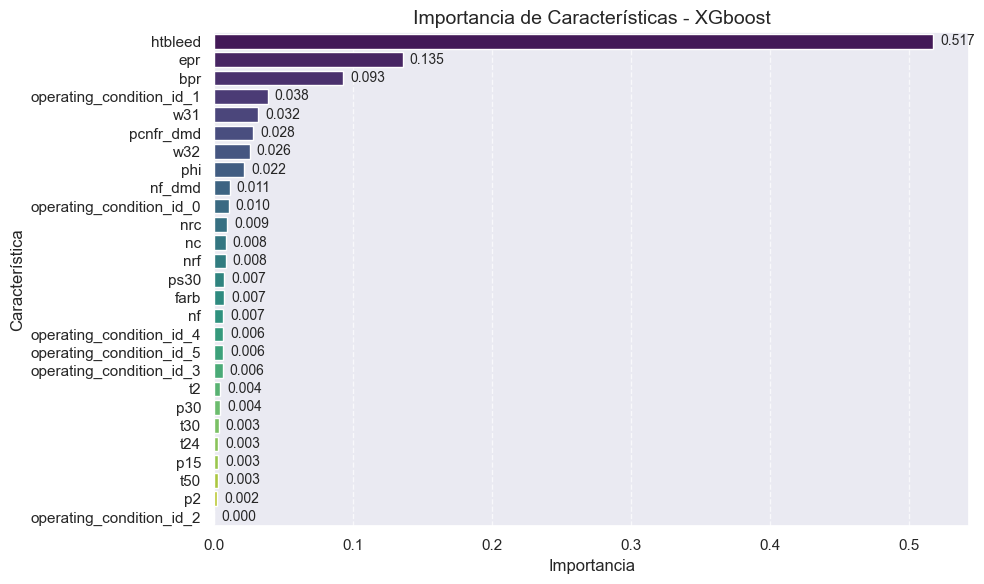

In [91]:
# Ordenar las importancias
# Crear dataframe de importancias
feat_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=feat_importances,
    x='Importance',
    y='Feature',
    color='#440154',  # Color principal de Viridis (puedes cambiarlo)
    hue='Feature',    # Asignamos hue para usar palette
    palette='viridis', # Paleta Viridis completa
    dodge=False,      # Evita que separen las barras
    legend=False      # No mostrar leyenda redundante
)

# Personalización del gráfico
plt.title('Importancia de Características - XGboost', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores de importancia a cada barra
for index, value in enumerate(feat_importances['Importance']):
    plt.text(value + 0.005,             # Posición X (valor + pequeño desplazamiento)
            index,                     # Posición Y (índice de la barra)
            f'{value:.3f}',            # Texto con 3 decimales
            va='center',               # Alineación vertical al centro
            fontsize=10)               # Tamaño de fuente

plt.tight_layout()
plt.show()

#### **REGRESIÓN LINEAL XGBOOST + ONE HOT ENCONDING + ESCALADO POR CONDICIÓN + SMOTHING (EXPERIMENTO 5).**

La idea es probar el experimento anterior con distintos valores de alpha (en el ajuste de hiperparámetros para el suavizado exponencial) y evaluar cómo afecta este filtro a la predicción.

##### Proceso.

In [25]:
sensor_names = sensor_names
condition_column = 'operating_condition_id'
group_column = 'unit_nr'

In [26]:
# ------------------------------
# ConditionScaler personalizado
# ------------------------------
from sklearn.base import BaseEstimator, TransformerMixin


class ConditionScaler(BaseEstimator, TransformerMixin):
    def __init__(self, feature_columns, condition_column='operating_condition_id'):
        self.feature_columns = feature_columns
        self.condition_column = condition_column
        self.scalers_dict_ = {}
        
    def fit(self, X, y=None):
        X = X.astype({col: 'float64' for col in self.feature_columns})
        for condition in X[self.condition_column].unique():
            scaler = StandardScaler()
            scaler.fit(X.loc[X[self.condition_column] == condition, self.feature_columns])
            self.scalers_dict_[condition] = scaler
        return self
        
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.feature_columns] = X_scaled[self.feature_columns].astype('float64')
        for condition, scaler in self.scalers_dict_.items():
            mask = X[self.condition_column] == condition
            X_scaled.loc[mask, self.feature_columns] = scaler.transform(X.loc[mask, self.feature_columns])
        return X_scaled

In [27]:
def time_series_smoothing(
    df: pd.DataFrame,
    group_columns: list = ["unit_nr"],
    feature_columns: list = None,
    alpha: float = 0.4,
    n_samples: int = 1
) -> pd.DataFrame:
    """
    Aplica suavizado exponencial a series temporales agrupadas y elimina muestras iniciales.

    Parámetros:
        df: DataFrame de entrada.
        group_columns: Columnas para agrupar (ej: ["unit_nr", "flight_id"]).
        feature_columns: Columnas a suavizar.
        alpha: Factor de suavizado (0 < alpha <= 1).
        n_samples: Muestras iniciales a eliminar por grupo.

    Retorna:
        DataFrame procesado.
    """
    df = df.copy()
    
    # 1. Suavizado Exponencial
    smoothed = (
        df.groupby(group_columns, sort=False)[feature_columns]
        .apply(lambda x: x.ewm(alpha=alpha).mean())
        .reset_index(level=0, drop=True)  # Alinear índices
    )
    
    df[feature_columns] = smoothed
    
    return df

In [28]:
def time_series_smoothing_wrapper(X, alpha=0.3):
    if isinstance(X, np.ndarray):
        raise ValueError("Expected a DataFrame, got ndarray instead.")
    return time_series_smoothing(
        X.copy(),
        group_columns=['unit_nr'],
        feature_columns=sensor_names,
        alpha=alpha,  # Ahora es un parámetro
        n_samples=1
    )

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class SmoothingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.3):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return time_series_smoothing_wrapper(X, alpha=self.alpha)

In [30]:
onehot_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), [condition_column]),
    ('drop', 'drop', group_column), 
], remainder='passthrough',
    force_int_remainder_cols=False)

In [31]:
from sklearn.pipeline import FunctionTransformer

xg_pipeline5 = Pipeline([
    ('condition_scaler', ConditionScaler(feature_columns=sensor_names, condition_column=condition_column)), # condición de operación
    ('smoother', SmoothingTransformer()),
    ('onehot_encoder', onehot_transformer),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=SEED, verbosity=0))
])

# Definir espacio de búsqueda
param_grid_xg5 = {
    'smoother__alpha': [0.3, 0.8],                 # alpha del smothing
    'model__n_estimators': [100, 200],        # Número de árboles
    'model__max_depth': [3, 10],           # Profundidad máxima
    'model__learning_rate': [0.01, 0.1, 1], # Tasa de aprendizaje
    'model__subsample': [0.8, 1.0],           # Porcentaje de muestras por árbol
    'model__colsample_bytree': [0.8, 1.0],     # Porcentaje de features por árbol
    'model__reg_alpha': [1],
    'model__reg_lambda': [1]
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)

In [32]:
grid_rf5 = GridSearchCV(xg_pipeline5, param_grid_xg5, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_rf5.fit(X_train[['unit_nr']+sensor_names+['operating_condition_id']], y_train_clipped)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=1, model__reg_lambda=1, model__subsample=0.8, smoother__alpha=0.3; neg_root_mean_squared_error: (train=-23.639, test=-25.804) r2: (train=0.672, test=0.607) total time=   6.6s
[CV 2/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=1, model__reg_lambda=1, model__subsample=0.8, smoother__alpha=0.3; neg_root_mean_squared_error: (train=-23.626, test=-25.806) r2: (train=0.672, test=0.608) total time=   5.2s
[CV 3/10] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__reg_alpha=1, model__reg_lambda=1, model__subsample=0.8, smoother__alpha=0.3; neg_root_mean_squared_error: (train=-23.613, test=-25.804) r2: (train=0.672, test=0.609) total time=   4.6s
[CV 4/10] END mo

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('condition_scaler',
                                        ConditionScaler(feature_columns=['t2',
                                                                         't24',
                                                                         't30',
                                                                         't50',
                                                                         'p2',
                                                                         'p15',
                                                                         'p30',
                                                                         'nf',
                                                                         'nc',
                                                                         'epr',
                                                                         'ps30',
                                                                         'phi',
                                                                         'nrf',
                                                                         'nrc',
                                                                         'bpr',
                                                                         'farb',
                                                                         'htbleed',
                                                                         'nf_dmd',
                                                                         'pcnfr_dmd',
                                                                         'w31',
                                                                         'w32'])),
                                       ('smoother', SmoothingTransformer()),
                                       ('onehot_encoder',
                                        ColumnT...
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 1],
                         'model__max_depth': [3, 10],
                         'model__n_estimators': [100, 200],
                         'model__reg_alpha': [1], 'model__reg_lambda': [1],
                         'model__subsample': [0.8, 1.0],
                         'smoother__alpha': [0.3, 0.8]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
# Guardar grid_rf
#joblib.dump(grid_rf5, 'grid_rf5_2.pkl')
#print("Modelo guardado exitosamente: 'grid_rf5_2.pkl'.")

Modelo guardado exitosamente: 'grid_rf5_2.pkl'.


In [34]:
#Cargar el GridSearchCV completo
#grid_rf5 = joblib.load('grid_rf5.pkl')
#print("Modelo cargado exitosamente.")

In [35]:
best_grid_xg5 = grid_rf5.best_estimator_

# Comparación de resultados
rf_rmse5 = -grid_rf5.best_score_
print(f"Mejor RMSE Random Forest: {rf_rmse5:.4f}, Mejor configuración: {grid_rf5.best_params_}")

Mejor RMSE Random Forest: 17.6669, Mejor configuración: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 1.0, 'smoother__alpha': 0.8}


##### Resultado

In [36]:
y_pred_train_5 = best_grid_xg5.predict(X_train[['unit_nr']+sensor_names+['operating_condition_id']])
y_pred_test_5 = best_grid_xg5.predict(X_test[['unit_nr']+sensor_names+['operating_condition_id']])

evaluate(y_train_clipped, y_pred_train_5, 'train')
evaluate(y_test.clip(upper=125), y_pred_test_5)

train set RMSE: 13.5862, R²: 0.8915
test set RMSE: 20.8119, R²: 0.7555


##### **IMPORTANCIA DE CARACTERÍSTICAS.**

In [37]:
importances = best_grid_xg5.named_steps['model'].feature_importances_

In [38]:
selected_features = sensor_names + [col for col in X_train_encoded.columns if col.startswith('operating_condition_id_')]

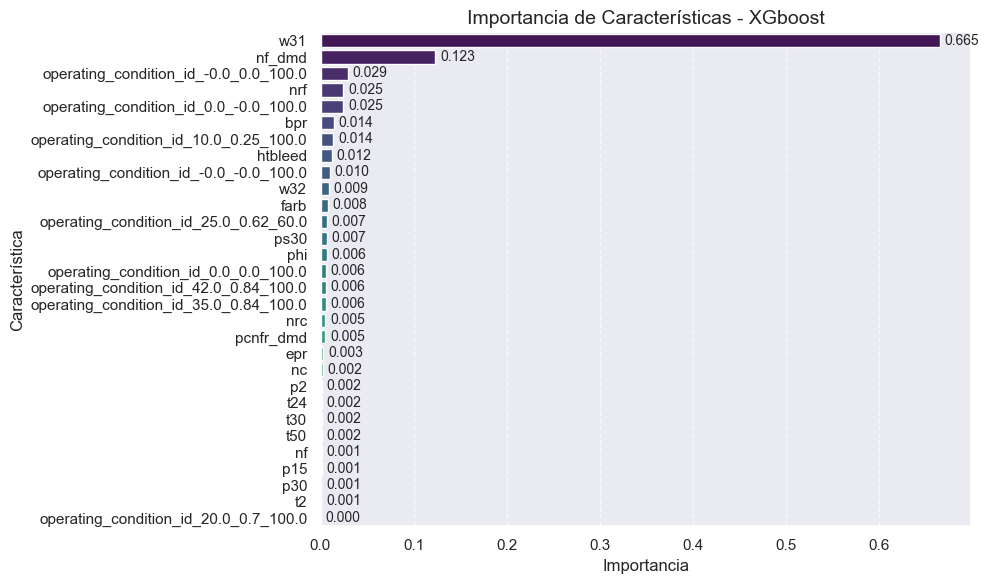

In [39]:
# Ordenar las importancias
# Crear dataframe de importancias
feat_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=feat_importances,
    x='Importance',
    y='Feature',
    color='#440154',  # Color principal de Viridis (puedes cambiarlo)
    hue='Feature',    # Asignamos hue para usar palette
    palette='viridis', # Paleta Viridis completa
    dodge=False,      # Evita que separen las barras
    legend=False      # No mostrar leyenda redundante
)

# Personalización del gráfico
plt.title('Importancia de Características - XGboost', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores de importancia a cada barra
for index, value in enumerate(feat_importances['Importance']):
    plt.text(value + 0.005,             # Posición X (valor + pequeño desplazamiento)
            index,                     # Posición Y (índice de la barra)
            f'{value:.3f}',            # Texto con 3 decimales
            va='center',               # Alineación vertical al centro
            fontsize=10)               # Tamaño de fuente

plt.tight_layout()
plt.show()

#### **REGRESION LINEAL XGBOOST (EXPERIMENTO 6).**

Pese a que demostramos que se tiene un mejor rendimiento con más características del dataset, realizamos aun feature selección para verificar si en modelos no lienales se mantiene el mismo patrón. Tambien hay que tomar en cuenta que los datos fueron preprocesados por fuera del pipeline, es decir se añadio la rul, la característica de la condición de operación y las dummies, se hizo el FIT con la variable X_train_encoded más la clip RUL.

##### Proceso.

In [ ]:
# Lista de valores para k (número de características)
k_values = [14, 27]

# Definir el pipeline con XGBoost
xgb_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_regression)),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=SEED, verbosity=0))
])

# Espacio de búsqueda de hiperparámetros
param_grid_xgb = {
    'feature_selection': k_values,
    'model__n_estimators': [100, 200],        # Número de árboles
    'model__max_depth': [3, 10],           # Profundidad máxima
    'model__learning_rate': [0.01, 0.1, 1], # Tasa de aprendizaje
    'model__subsample': [0.8, 1.0],           # Porcentaje de muestras por árbol
    'model__colsample_bytree': [0.8, 1.0]     # Porcentaje de features por árbol
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

In [ ]:
# Optimización con GridSearchCV 
grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf, verbose=4)
grid_xgb.fit(X_train_encoded, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END feature_selection__k=27, model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; neg_root_mean_squared_error: (train=-30.339, test=-30.386) r2: (train=0.459, test=0.456) total time= 1.1min
[CV 2/10] END feature_selection__k=27, model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; neg_root_mean_squared_error: (train=-30.337, test=-30.247) r2: (train=0.459, test=0.462) total time= 1.3min
[CV 3/10] END feature_selection__k=27, model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; neg_root_mean_squared_error: (train=-30.349, test=-30.356) r2: (train=0.458, test=0.459) total time=  60.0s
[CV 4/10] END feature_selection__k=27, model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_est

c:\Users\equipo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
4 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\equipo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\equipo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\equipo\App

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function mutual_info_regression at 0x0000020BF895C720>)),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stop...
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'feature_selection__k': [27],
                         'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 10],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
best_grid_xgb = grid_xgb.best_estimator_

In [ ]:
# Guardar grid_ridge
#joblib.dump(grid_xgb, 'grid_XG_full_clip.pkl')

# Guardar best_ridge
#joblib.dump(best_grid_xgb, 'XG_best_model_clip.pkl')

#print("Modelos guardados exitosamente: 'grid_XG_full_clip.pkl' y 'XG_best_model_clip.pkl'.")

Modelos guardados exitosamente: 'grid_XG_full_clip.pkl' y 'XG_best_model_clip.pkl'.


In [ ]:
# Cargar el GridSearchCV completo
#grid_xgb= joblib.load('grid_XG_full_clip.pkl')

# Cargar el mejor modelo
#best_grid_xgb= joblib.load('XG_best_model_clip.pkl')

#print("Modelos cargados exitosamente.")


Modelos cargados exitosamente.


In [111]:
best_grid_xgb = grid_xgb.best_estimator_

# Comparación de resultados
xgboost_rmse = -grid_xgb.best_score_
print(f"Mejor RMSE XGboost: {xgboost_rmse:.4f}, Mejor configuración: {grid_xgb.best_params_}")

Mejor RMSE XGboost: 18.0166, Mejor configuración: {'feature_selection__k': 27, 'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__subsample': 1.0}


##### Resultado.

In [112]:
# Hacer predicciones con el mejor modelo
y_hat_trainreg = best_grid_xgb.predict(X_train_encoded)
y_hat_testreg = best_grid_xgb.predict(X_test_encoded)

# Evaluar el rendimiento del modelo en el conjunto de prueba
evaluate(y_train, y_hat_trainreg, 'train')
evaluate(y_test.clip(upper=125), y_hat_testreg)

train set RMSE: 14.9625, R²: 0.8684
test set RMSE: 18.3032, R²: 0.8109


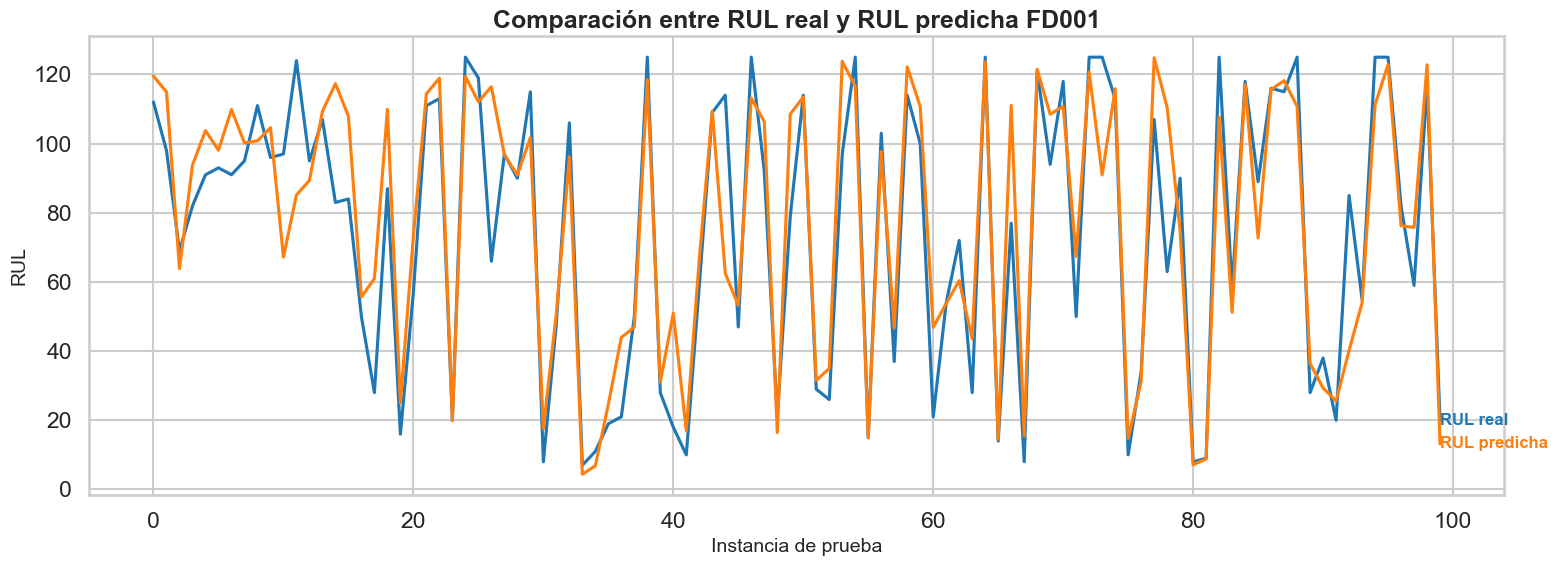

In [113]:
# Estilo de Seaborn
sns.set(style="whitegrid", context="talk")

# Crear DataFrame con resultados
df_resultados = pd.DataFrame({
    'RUL real': y_test[:100].clip(upper=125),
    'RUL predicha': y_hat_testreg[:100]
})

plt.figure(figsize=(16, 6))
sns.lineplot(data=df_resultados['RUL real'], label=None, color='#1f77b4')
sns.lineplot(data=df_resultados['RUL predicha'], label=None, color='#ff7f0e')

# Añadir texto directamente en las curvas
plt.text(len(df_resultados)-1, df_resultados['RUL real'].iloc[-1], 'RUL real',
         color='#1f77b4', fontsize=12, va='center', ha='left', fontweight='bold')

plt.text(len(df_resultados)-1, df_resultados['RUL predicha'].iloc[-1], 'RUL predicha',
         color='#ff7f0e', fontsize=12, va='center', ha='left', fontweight='bold')

plt.title('Comparación entre RUL real y RUL predicha FD001', fontsize=18, weight='bold')
plt.xlabel('Instancia de prueba', fontsize=14)
plt.ylabel('RUL', fontsize=14)

plt.tight_layout()
plt.show()

##### **CURVAS DE APRENDIZAJE.**

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    best_grid_xgb, X_train_encoded, y_train, cv=rkf, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

In [ ]:
train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

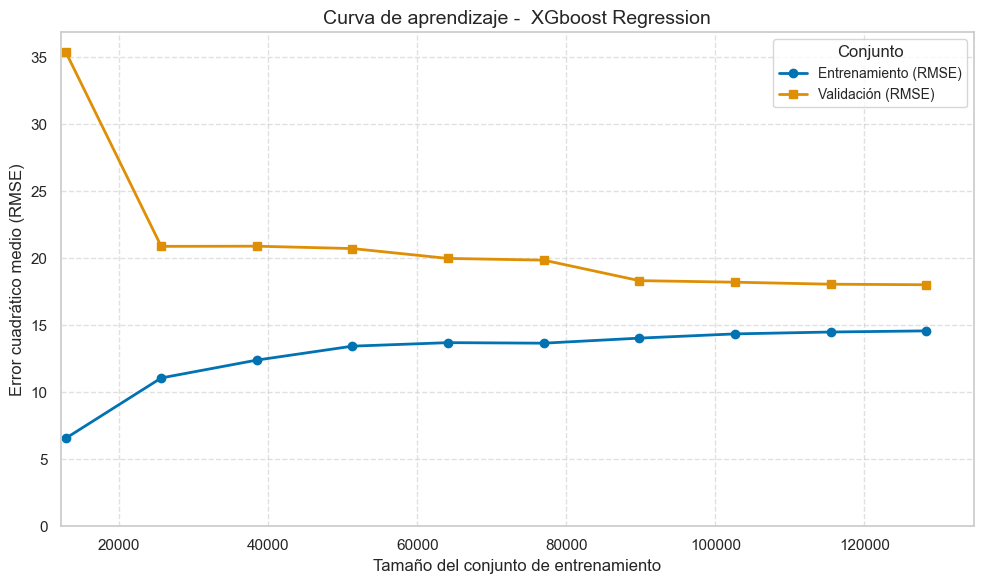

In [71]:
# Estilo general
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Colores accesibles con contraste
colors = sns.color_palette("colorblind")

# Líneas con marcadores y bordes para mejor visibilidad
plt.plot(train_sizes, train_rmse, label='Entrenamiento (RMSE)', marker='o', color=colors[0], linewidth=2)
plt.plot(train_sizes, val_rmse, label='Validación (RMSE)', marker='s', color=colors[1], linewidth=2)

# Etiquetas y título con tipografía clara
plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Error cuadrático medio (RMSE)', fontsize=12)
plt.title('Curva de aprendizaje -  XGboost Regression', fontsize=14)

# Límites bien ajustados sin recortar líneas
plt.ylim(bottom=0)  # evita que el eje Y recorte datos
plt.xlim([min(train_sizes)*0.95, max(train_sizes)*1.05])

# Leyenda clara con mejor contraste
plt.legend(title='Conjunto', loc='upper right', fontsize=10)

# Cuadrícula sutil
plt.grid(True, linestyle='--', alpha=0.6)

# Acomodar todo bien al canvas
plt.tight_layout()
plt.show()

El RMSE de validación disminuye de manera significativa al aumentar el tamaño del conjunto de entrenamiento, lo que indica que el modelo se beneficia claramente de tener más datos. Esto es un buen signo: el modelo generaliza mejor con más muestras.

##### **IMPORTANCIA DE CARACTERÍSTICAS.**

In [55]:
importances = best_grid_xgb.named_steps['model'].feature_importances_

In [56]:
selected_mask = best_grid_xgb.named_steps['feature_selection'].get_support()
selected_features = X_train_encoded.columns[selected_mask] 

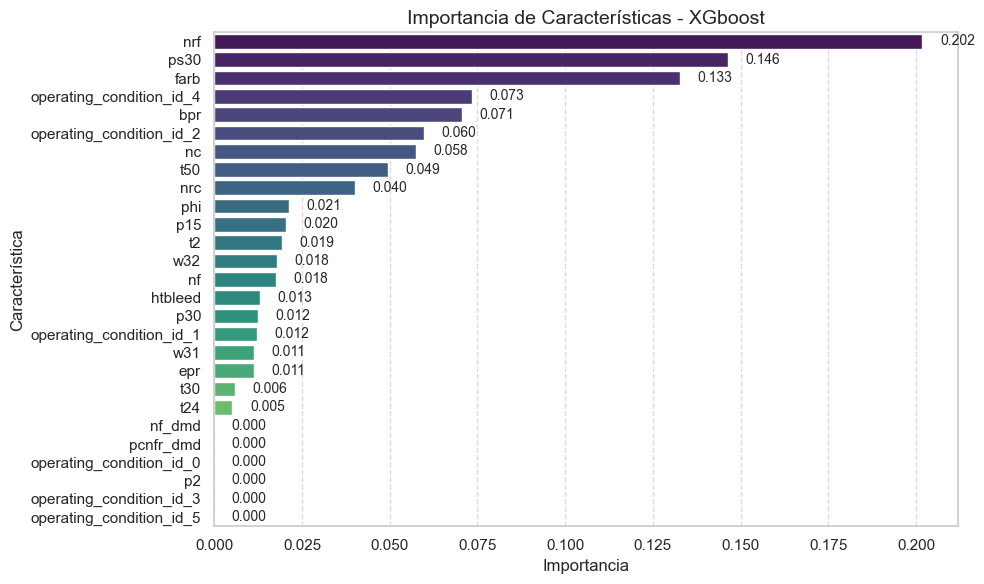

In [73]:
# Ordenar las importancias
# Crear dataframe de importancias
feat_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Gráfico
sns.barplot(
    data=feat_importances,
    x='Importance',
    y='Feature',
    color='#440154',  # Color principal de Viridis (puedes cambiarlo)
    hue='Feature',    # Asignamos hue para usar palette
    palette='viridis', # Paleta Viridis completa
    dodge=False,      # Evita que separen las barras
    legend=False      # No mostrar leyenda redundante
)

# Personalización del gráfico
plt.title('Importancia de Características - XGboost', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores de importancia a cada barra
for index, value in enumerate(feat_importances['Importance']):
    plt.text(value + 0.005,             # Posición X (valor + pequeño desplazamiento)
            index,                     # Posición Y (índice de la barra)
            f'{value:.3f}',            # Texto con 3 decimales
            va='center',               # Alineación vertical al centro
            fontsize=10)               # Tamaño de fuente

plt.tight_layout()
plt.show()

La imágen muestra un análisis de importancia de características (feature importance) para un modelo XGBoost, donde se destacan variables como operating_condition_id_4 (con importancia 0.133) y htbledd (con valores entre 0.048 y 0.073) como las más relevantes para predecir el objetivo. Muchas otras características (como pcnfr_dmd o operating_condition_id_0) tienen una importancia cercana a cero, lo que sugiere que podrían eliminarse sin afectar el rendimiento del modelo. El gráfico ayuda a identificar qué variables influyen más en las predicciones, permitiendo optimizar el modelo al enfocarse solo en los factores clave.

##### **Reentrenar el modelo con las características que más aportan.**

In [84]:
# Extraer importancia de características
importances = best_grid_xgb.named_steps['model'].feature_importances_
selected_features_mask = best_grid_xgb.named_steps['feature_selection'].get_support()
feature_names = X_train_encoded.columns[selected_features_mask]

# Crear DataFrame de importancias
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

In [93]:
# Seleccionar top N características
top_n = 20
top_features = feat_imp_df.head(top_n)['Feature'].values

# Filtrar conjuntos de datos
X_train_top = X_train_encoded[top_features]
X_test_top = X_test_encoded[top_features]

In [ ]:
# Pipeline simplificado para reevaluación
# Pipeline con XGBoost y los mejores parámetros obtenidos
xgb_reeval = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(
        n_estimators=100,            # Del mejor GridSearch
        max_depth=10,                 # Del mejor GridSearch
        learning_rate=0.1,            # Del mejor GridSearch
        subsample=1.0,                # Del mejor GridSearch
        colsample_bytree=0.8,         # Del mejor GridSearch
        random_state=SEED,              # Para reproducibilidad
        objective='reg:squarederror'  # Para problemas de regresión
    ))
])

In [95]:
# Entrenamiento y evaluación
xgb_reeval.fit(X_train_top, y_train)
y_pred = xgb_reeval.predict(X_test_top)
y_pred_train = xgb_reeval.predict(X_train_top)

In [96]:
evaluate(y_train, y_pred_train, 'train')
evaluate(y_test.clip(upper=125), y_pred)

train set RMSE: 15.0951, R²: 0.8660
test set RMSE: 18.3939, R²: 0.8090


Cuando reentrenamos el mejor modelo con las mejores 20 características o las mas importantes este sufre un pequeño bajon de rendimiento en comparación con el modelo optimizado (test set RMSE: 18.3032, R²: 0.8109), lo que confirma de una vez que el modelo mejora con mas características por mas ligera que esta sea. 

Realmente lo que me interesa saber es que si este tipo de modelos basados en árboles, robustos frente a relaciones complejas o no lineales mejora con ciertos ajustes o refinamiento en el pre-procesmiento de los datos, como escalar por condición de operación y probar el filtro de ruido, antes de entrar de lleno a modelos de redes neuronales para series de tiempo.

### **CONCLUSIONES.**

- El modelo tiene test set RMSE: 18.3032, R²: 0.8109 y mejora con mas caracteristicas del  dataset, sus métricas son buenas pero aun se pueden mejorar probando otros modelos que representen de mejor manera la tendencias temporales de los datos LSTM y Transformers serán probados proponiendo diferentes arquitecturas.

-  Limitar el RUL (evitando valores extremos) y escalar características son críticos para modelos de mantenimiento predictivo, debido al gran cambio de resultados entre el experimentoo 1 y 2, lo cual sugiere que una adecuada transformación de la variable objetivo y normalización de entradas es fundamental.

- Al aplicar OHE (Experimento 3), el desempeño mejora ligeramente en test (R² = 0.8108), mostrando que aunque XGBoost puede manejar variables categóricas codificadas como enteros, incorporar dummies puede ayudar marginalmente.

- El escalado por condición de operación (Experimento 4) mejora ligeramente el desempeño en entrenamiento, pero no tanto en test (R² baja a 0.8045) aumenta ligeramente overfitting. Esto puede deberse a que el modelo ya es suficientemente robusto al escalado global, o que el agrupamiento por condición no aporta suficiente diferenciación en este modelo, sera muy bueno realizar pruebas en los modelos de series de tiempo entre el escalado global y por condición.

- El Experimento 5 empeora notablemente el rendimiento en test (R² = 0.7598). Esto sugiere que el suavizado puede atenuar señales importantes para el modelo, eso que el mejor valor de alpha fue 0.8, es decir el menos estricto.

- El cambio de un escalado global a un escalado por condición de operación (Experimento 3 vs. Experimento 4) puede alterar la distribución y el rango numérico de las características, modificando así el contraste entre variables. Aunque XGBoost no es sensible a la escala de manera directa, este cambio puede afectar el orden de los splits y la ganancia de información, lo que conlleva una variación en la importancia asignada a cada característica. Esto sugiere que algunas variables se vuelven más informativas en contextos operacionales específicos, lo cual impacta directamente en la estructura del modelo

### **RECOMENDACIONES.**

- No omitir el preprocesamiento el Clipping de RUL y escalado global son fundamentales para estabilizar el modelo y mejorar la generalización.

- OHE puede aportar valor, pero la ganancia es marginal, de todas formas sera probadas en modelos de series temporales. En modelos más complejos, puede ser más útil si hay más categorías o interacciones relevantes.

- El escalado por condición y el suavizado deben validarse cuidadosamente, ya que pueden introducir ruido o perder información útil, seria útil probar la idea de aplicar el filtro despues de escalamiento.